# Classification - Customer Satisfaction Rate

# 0.0. Imports

In [1]:
#Import Libraries
import numpy as np
import pandas as pd

import pickle
import inflection

from ydata_profiling import ProfileReport

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import ensemble as en
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn import metrics as mt
from sklearn import model_selection as ms
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# 0.1. Functions and Settings

In [2]:
#Functions and Settings

#Setting float data format
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

#Setting Plot configuration
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]

#Setting Parameters - Cross Validation
cv = 5
scoring = 'precision'

#Rename dataframe columns
def rename_cols(df, train=True):
    if train == True:
        cols_old = ['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase',
           'Store size', 'Store distance', 'InStore wifi',
           'Open/Close time convenient', 'Easy of online shopping',
           'Store location', 'Toilet cleaning', 'Dressing room', 'Waiting room',
           'Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store',
           'Purchase service', 'Store Service', 'Cleanliness',
           'Carrier delay in minutes', 'Delivery delay in minutes',
           'Satisfaction']
    else:
        cols_old = ['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase',
           'Store size', 'Store distance', 'InStore wifi',
           'Open/Close time convenient', 'Easy of online shopping',
           'Store location', 'Toilet cleaning', 'Dressing room', 'Waiting room',
           'Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store',
           'Purchase service', 'Store Service', 'Cleanliness',
           'Carrier delay in minutes', 'Delivery delay in minutes']
    
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(' ', '_')
    
    return df

#Feature Engineering
def feature_eng(df, train=True):
    #Label Encoder
    gender_le = LabelEncoder()
    df['gender'] = gender_le.fit_transform(df['gender'])

    cust_type_le = LabelEncoder()
    df['customer_type'] = cust_type_le.fit_transform(df['customer_type'])

    type_purc_le = LabelEncoder()
    df['type_of_purchase'] = type_purc_le.fit_transform(df['type_of_purchase'])

    st_size_le = LabelEncoder()
    df['store_size'] = st_size_le.fit_transform(df['store_size'])

    if train == True:
        satisfaction_dict = {'Neutral or Dissatisfaction': 0,  'Satisfied':1}
        df['satisfaction'] = df['satisfaction'].map(satisfaction_dict)

    #Data Types Adjusting
    df['gender'] = df['gender'].astype('int64')
    df['customer_type'] = df['customer_type'].astype('int64')
    df['type_of_purchase'] = df['type_of_purchase'].astype('int64')
    df['store_size'] = df['store_size'].astype('int64')

    if train == True:
        df['satisfaction'] = df['satisfaction'].astype('int64')

    return df

#Setting train/test data to algorithm application
def feature_opt(df):
    mms = MinMaxScaler()
    rs = RobustScaler()

    #MinMaxScaler and Robust Scaler
    df['age'] = mms.fit_transform(df[['age']].values)
    df['store_distance'] = rs.fit_transform(df[['store_distance']].values)
    df['carrier_delay_in_minutes'] = rs.fit_transform(df[['carrier_delay_in_minutes']].values)
    df['delivery_delay_in_minutes'] = rs.fit_transform(df[['delivery_delay_in_minutes']].values)

    return df

# 1.0. Data Description

## 1.1. Loading Data

In [3]:
#Import Train Data 
df_train = pd.read_csv('data/train.csv')

#Import Test Data
df_test = pd.read_csv('data/test.csv')

## 1.2. Rename Columns

In [4]:
#Backup Datasets
df1 = df_train.copy()
df1_x = df_test.copy()

In [5]:
#Applying Rename Columns Function
df1 = rename_cols(df1, train=True)
df1_x = rename_cols(df1_x, train=False)

## 1.3. Data Dimensions

In [6]:
#Checking number of rows and columns of the dataframe
print('Train Number of rows: {}'.format(df1.shape[0]))
print('Train Number of cols: {}'.format(df1.shape[1]))
print('\n')
print('Test Number of rows: {}'.format(df1_x.shape[0]))
print('Test Number of cols: {}'.format(df1_x.shape[1]))

Train Number of rows: 103904
Train Number of cols: 24


Test Number of rows: 25976
Test Number of cols: 23


## 1.4. Check NA

In [7]:
#Check of NA's values of train dataframe
df1.isna().sum()

id                              0
gender                          0
customer_type                   0
age                             0
type_of_purchase                0
store_size                      0
store_distance                  0
in_store_wifi                   0
open/close_time_convenient      0
easy_of_online_shopping         0
store_location                  0
toilet_cleaning                 0
dressing_room                   0
waiting_room                    0
kids_entertainment              0
seller_service                  0
showroom                        0
self_store                      0
purchase_service                0
store_service                   0
cleanliness                     0
carrier_delay_in_minutes        0
delivery_delay_in_minutes     310
satisfaction                    0
dtype: int64

In [8]:
#Check of NA's values of test dataframe
df1_x.isna().sum()

id                             0
gender                         0
customer_type                  0
age                            0
type_of_purchase               0
store_size                     0
store_distance                 0
in_store_wifi                  0
open/close_time_convenient     0
easy_of_online_shopping        0
store_location                 0
toilet_cleaning                0
dressing_room                  0
waiting_room                   0
kids_entertainment             0
seller_service                 0
showroom                       0
self_store                     0
purchase_service               0
store_service                  0
cleanliness                    0
carrier_delay_in_minutes       0
delivery_delay_in_minutes     83
dtype: int64

### 1.4.1. Drop / Replace NA's

In [9]:
#Replace NA's from train dataframe
df1['delivery_delay_in_minutes'] = df1['delivery_delay_in_minutes'].fillna(df1['delivery_delay_in_minutes'].median())

#Replace NA's from test dataframe
df1_x['delivery_delay_in_minutes'] = df1_x['delivery_delay_in_minutes'].fillna(df1_x['delivery_delay_in_minutes'].median())

## 1.5. Data Dtypes

In [10]:
#Checking train data dtypes
df1.dtypes

id                              int64
gender                         object
customer_type                  object
age                             int64
type_of_purchase               object
store_size                     object
store_distance                  int64
in_store_wifi                   int64
open/close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self_store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
satisfaction                   object
dtype: object

In [11]:
#Checking test data dtypes
df1_x.dtypes

id                              int64
gender                         object
customer_type                  object
age                             int64
type_of_purchase               object
store_size                     object
store_distance                  int64
in_store_wifi                   int64
open/close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self_store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
dtype: object

## 1.6. Exploratory Data Analysis (EDA)

### 1.6.1 Pandas Profiling

In [12]:
#Report for Data Analysis
profile = ProfileReport(df1)

#Export Report to External Data Analysis
profile.to_file(output_file='Profile_Report.html')

#Show Report
#profile

### Pandas Profiling Analysis

> Data Balancing:

Satisfaction (Responde Variable): Neutral or Dissatisfaction (57%) x Satisfied (43%) 

Gender: Female (51%) x Male (49%) - Balanced Data

Customer Type: Loyal (82%) x Disloyal (18%)

Type of Purchase: Gift (69%) x Personal (31%)

Store Size: Large (48%) x Medium (45%) x Small (7%)

Client Valuation Data (0-5):

4 (Most Common): open/close time convenient / toilet cleaning / dressing room / waiting room / kids entertainment / seller service / showroom / purchase service / store service / cleanliness

---
> Most relevancies on the Target Variable (Correlations - Heat Map):

in_store_wifi / dressing_room / type_of_purchase / store_size / waiting_room / kids_entertainment

---
>Most Common Values:

0 (56%): carrier delay in minutes

0 (56%): delivery delay in minutes


### 1.6.2 Statistical Analysis

In [13]:
#Train Data distribution analysis
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,103904.00,64924.21,37463.81,1.00,32533.75,64856.50,97368.25,129880.00
age,103904.00,39.38,15.11,7.00,27.00,40.00,51.00,85.00
store_distance,103904.00,1189.45,997.15,31.00,414.00,843.00,1743.00,4983.00
in_store_wifi,103904.00,2.73,1.33,0.00,2.00,3.00,4.00,5.00
open/close_time_convenient,103904.00,3.06,1.53,0.00,2.00,3.00,4.00,5.00
easy_of_online_shopping,103904.00,2.76,1.40,0.00,2.00,3.00,4.00,5.00
store_location,103904.00,2.98,1.28,0.00,2.00,3.00,4.00,5.00
toilet_cleaning,103904.00,3.20,1.33,0.00,2.00,3.00,4.00,5.00
dressing_room,103904.00,3.25,1.35,0.00,2.00,3.00,4.00,5.00
waiting_room,103904.00,3.44,1.32,0.00,2.00,4.00,5.00,5.00


In [14]:
#Test Data distribution analysis
df1_x.describe().T

,count,mean,std,min,25%,50%,75%,max
id,25976.00,65005.66,37611.53,17.00,32170.50,65319.50,97584.25,129877.00
age,25976.00,39.62,15.14,7.00,27.00,40.00,51.00,85.00
store_distance,25976.00,1193.79,998.68,31.00,414.00,849.00,1744.00,4983.00
in_store_wifi,25976.00,2.72,1.34,0.00,2.00,3.00,4.00,5.00
open/close_time_convenient,25976.00,3.05,1.53,0.00,2.00,3.00,4.00,5.00
easy_of_online_shopping,25976.00,2.76,1.41,0.00,2.00,3.00,4.00,5.00
store_location,25976.00,2.98,1.28,1.00,2.00,3.00,4.00,5.00
toilet_cleaning,25976.00,3.22,1.33,0.00,2.00,3.00,4.00,5.00
dressing_room,25976.00,3.26,1.36,0.00,2.00,4.00,4.00,5.00
waiting_room,25976.00,3.45,1.32,1.00,2.00,4.00,5.00,5.00


In [15]:
#Selecting data types for analysis
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(exclude=['int64', 'float64'])

### Numerical Attributes

In [16]:
#Central tendency - mean, median
ct1 = pd.DataFrame(num_att.apply(np.mean)).T
ct2 = pd.DataFrame(num_att.apply(np.median)).T

#Dispertion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_att.apply(np.std)).T
d2 = pd.DataFrame(num_att.apply(min)).T
d3 = pd.DataFrame(num_att.apply(max)).T
d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

#Concatenate
num_att_analysis = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_att_analysis.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

#Data for analysis
num_att_analysis

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00,129880.00,129879.00,64924.21,64856.50,37463.63,0.00,-1.20
1,age,7.00,85.00,78.00,39.38,40.00,15.11,-0.00,-0.72
2,store_distance,31.00,4983.00,4952.00,1189.45,843.00,997.14,1.11,0.27
3,in_store_wifi,0.00,5.00,5.00,2.73,3.00,1.33,0.04,-0.85
4,open/close_time_convenient,0.00,5.00,5.00,3.06,3.00,1.53,-0.33,-1.04
5,easy_of_online_shopping,0.00,5.00,5.00,2.76,3.00,1.40,-0.02,-0.91
6,store_location,0.00,5.00,5.00,2.98,3.00,1.28,-0.06,-1.03
7,toilet_cleaning,0.00,5.00,5.00,3.20,3.00,1.33,-0.15,-1.15
8,dressing_room,0.00,5.00,5.00,3.25,3.00,1.35,-0.45,-0.70
9,waiting_room,0.00,5.00,5.00,3.44,4.00,1.32,-0.48,-0.93


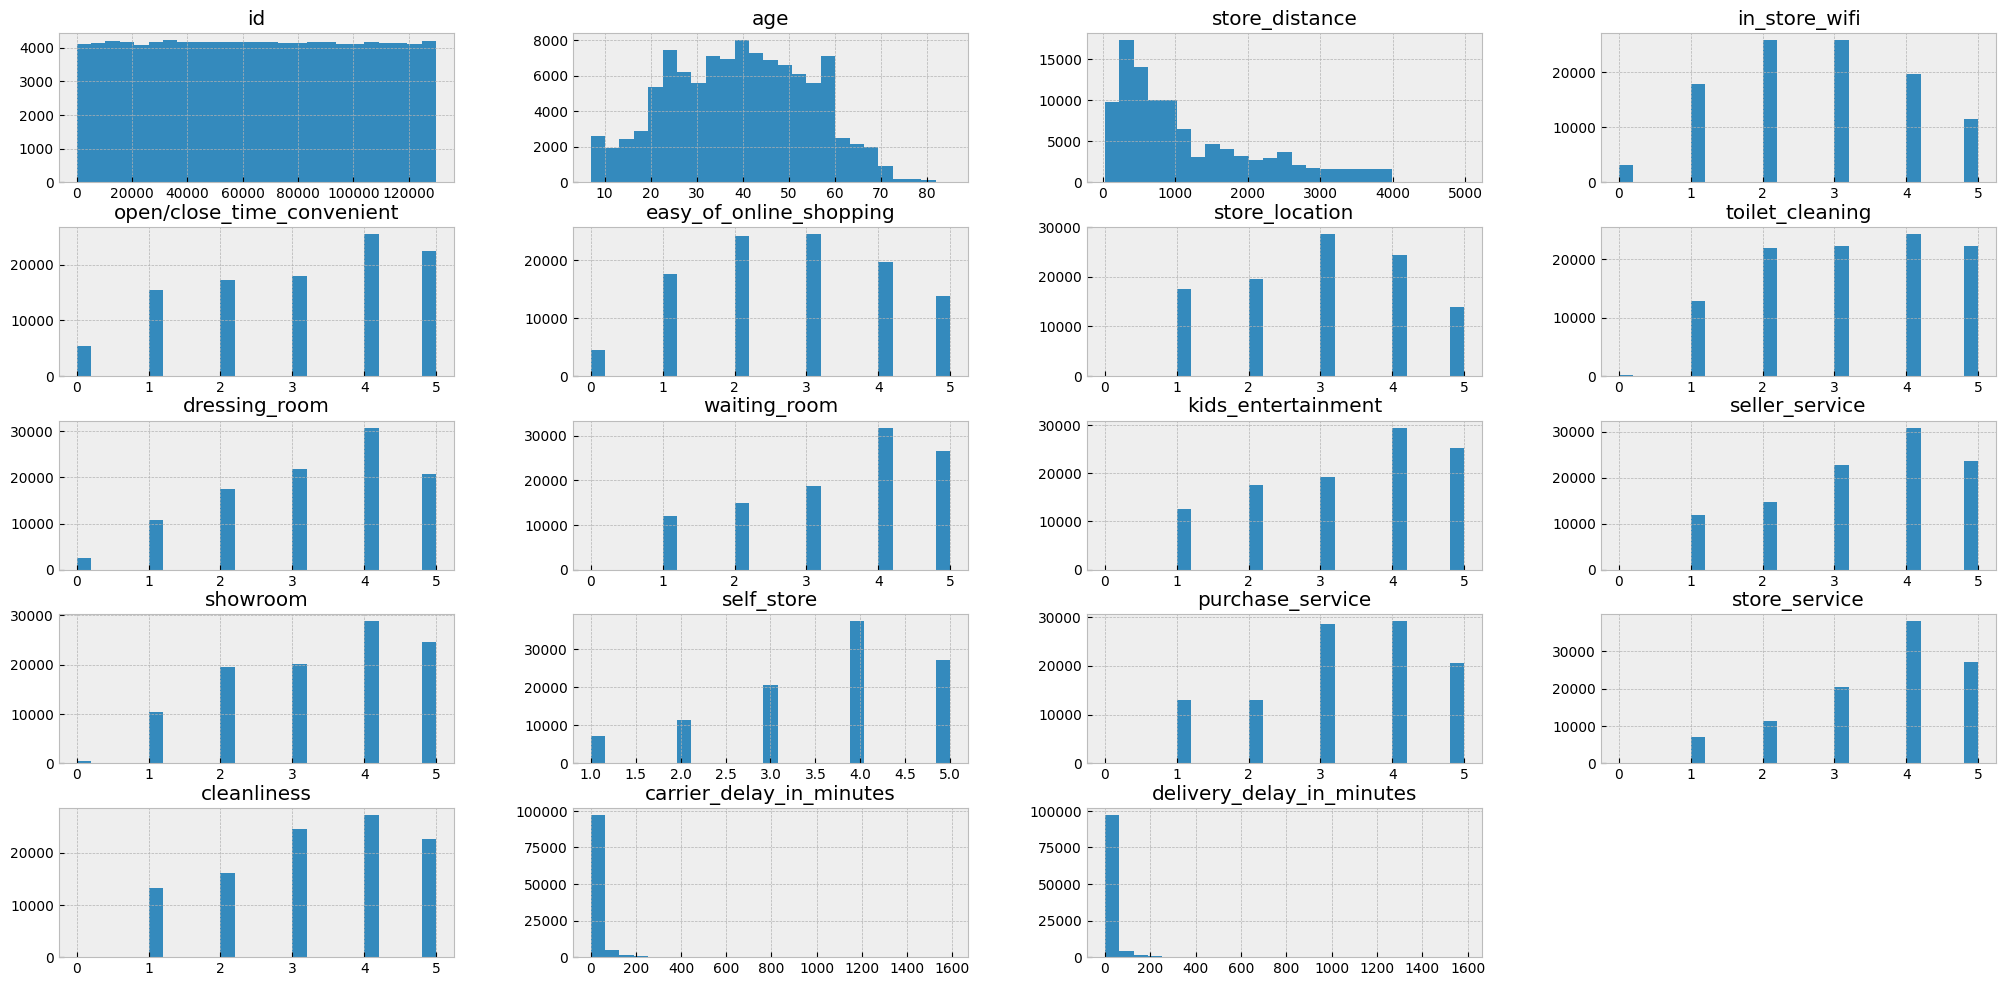

In [17]:
#Checking numerical attributes data on graphs
df1.hist(bins=25);

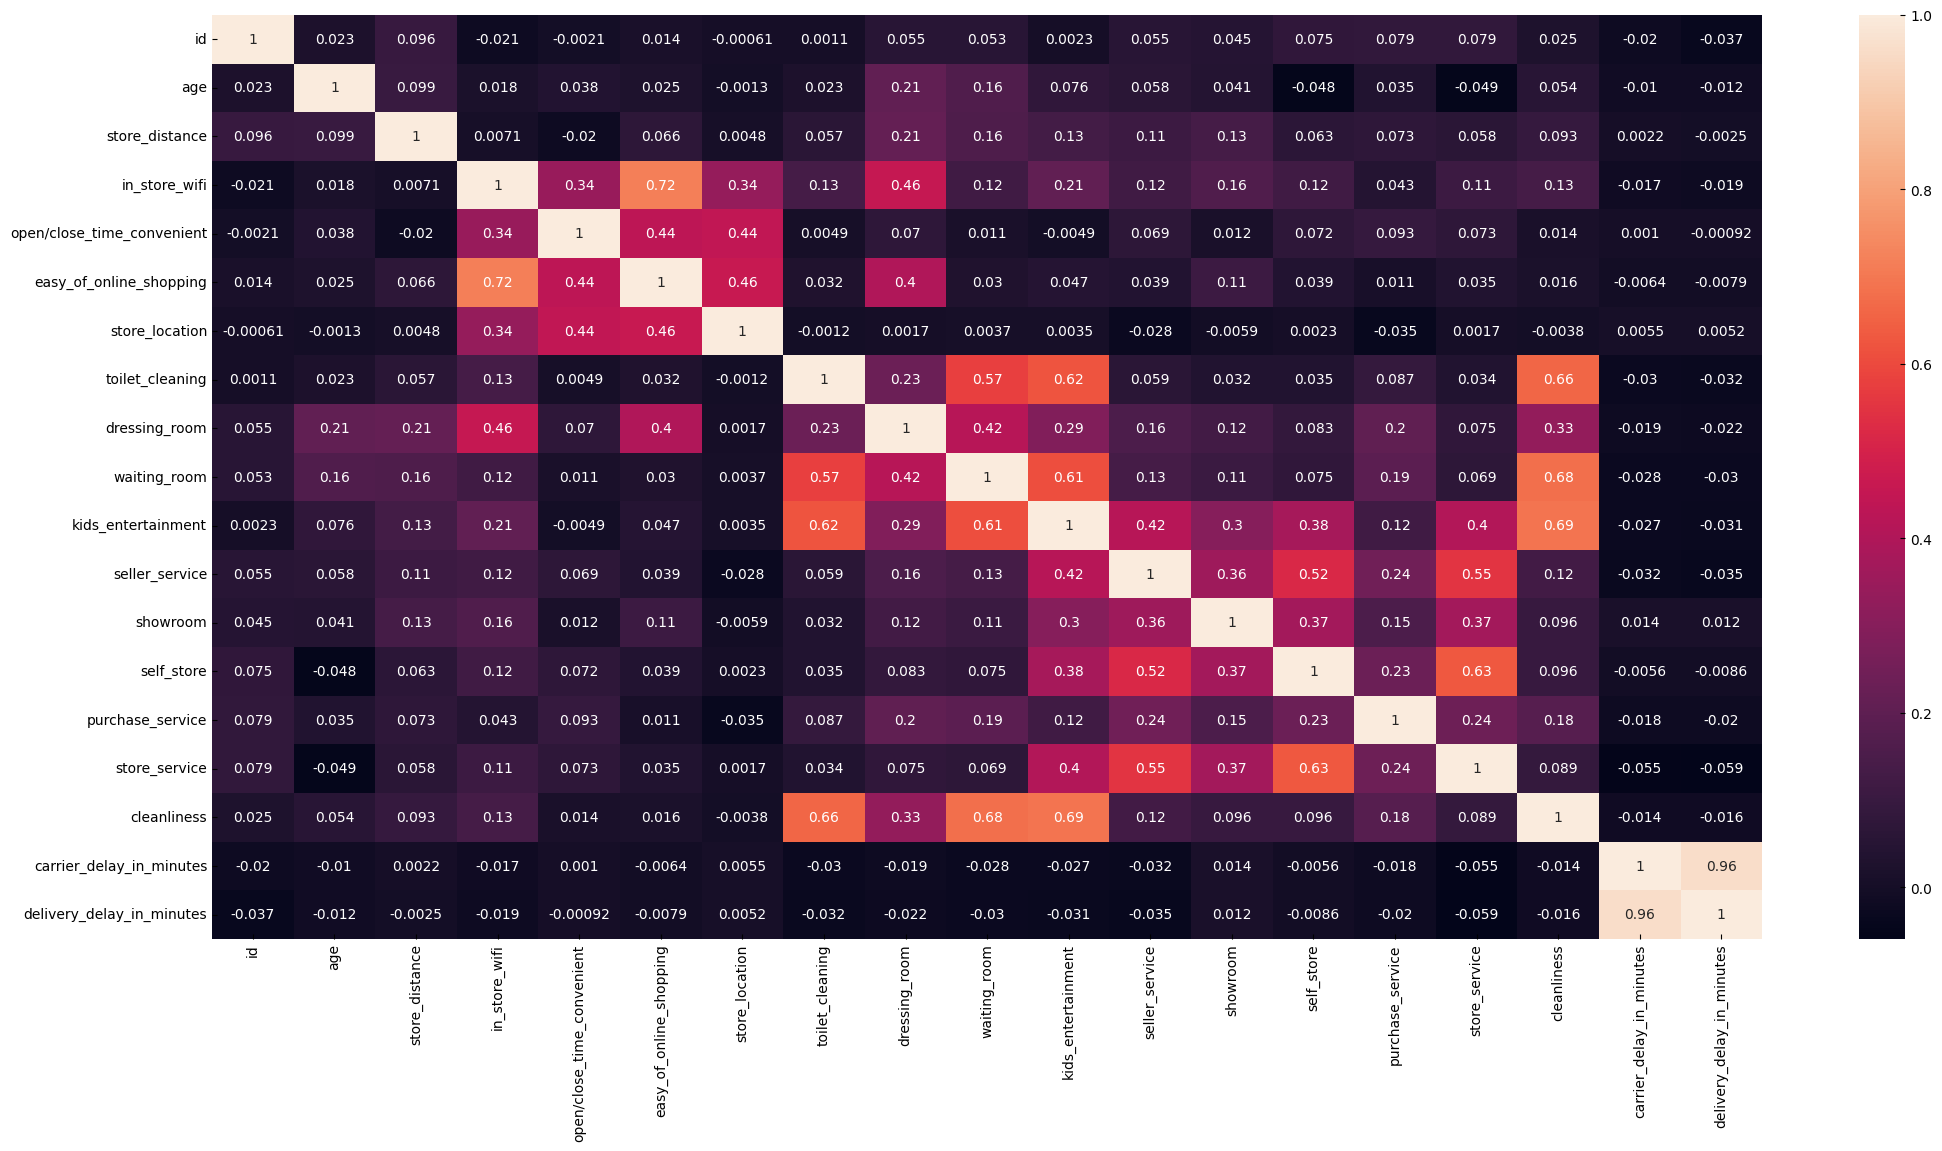

In [18]:
#Correlation - Heat Map
hmap = num_att.corr(method='pearson')
sns.heatmap(hmap, annot=True);

### Categorical Attributes

In [19]:
#Checking unique categorical values
cat_att.apply(lambda x: x.unique().shape[0])

gender              2
customer_type       2
type_of_purchase    2
store_size          3
satisfaction        2
dtype: int64

In [20]:
#Analysis of categorical values
print('gender: {}'.format(cat_att['gender'].unique()))
print('customer_type: {}'.format(cat_att['customer_type'].unique()))
print('type_of_purchase: {}'.format(cat_att['type_of_purchase'].unique()))
print('store_size: {}'.format(cat_att['store_size'].unique()))
print('satisfaction: {}'.format(cat_att['satisfaction'].unique()))

gender: ['Male' 'Female']
customer_type: ['Loyal Customer' 'disloyal Customer']
type_of_purchase: ['Personal' 'Gift']
store_size: ['Small' 'Large' 'Medium']
satisfaction: ['Neutral or Dissatisfaction' 'Satisfied']


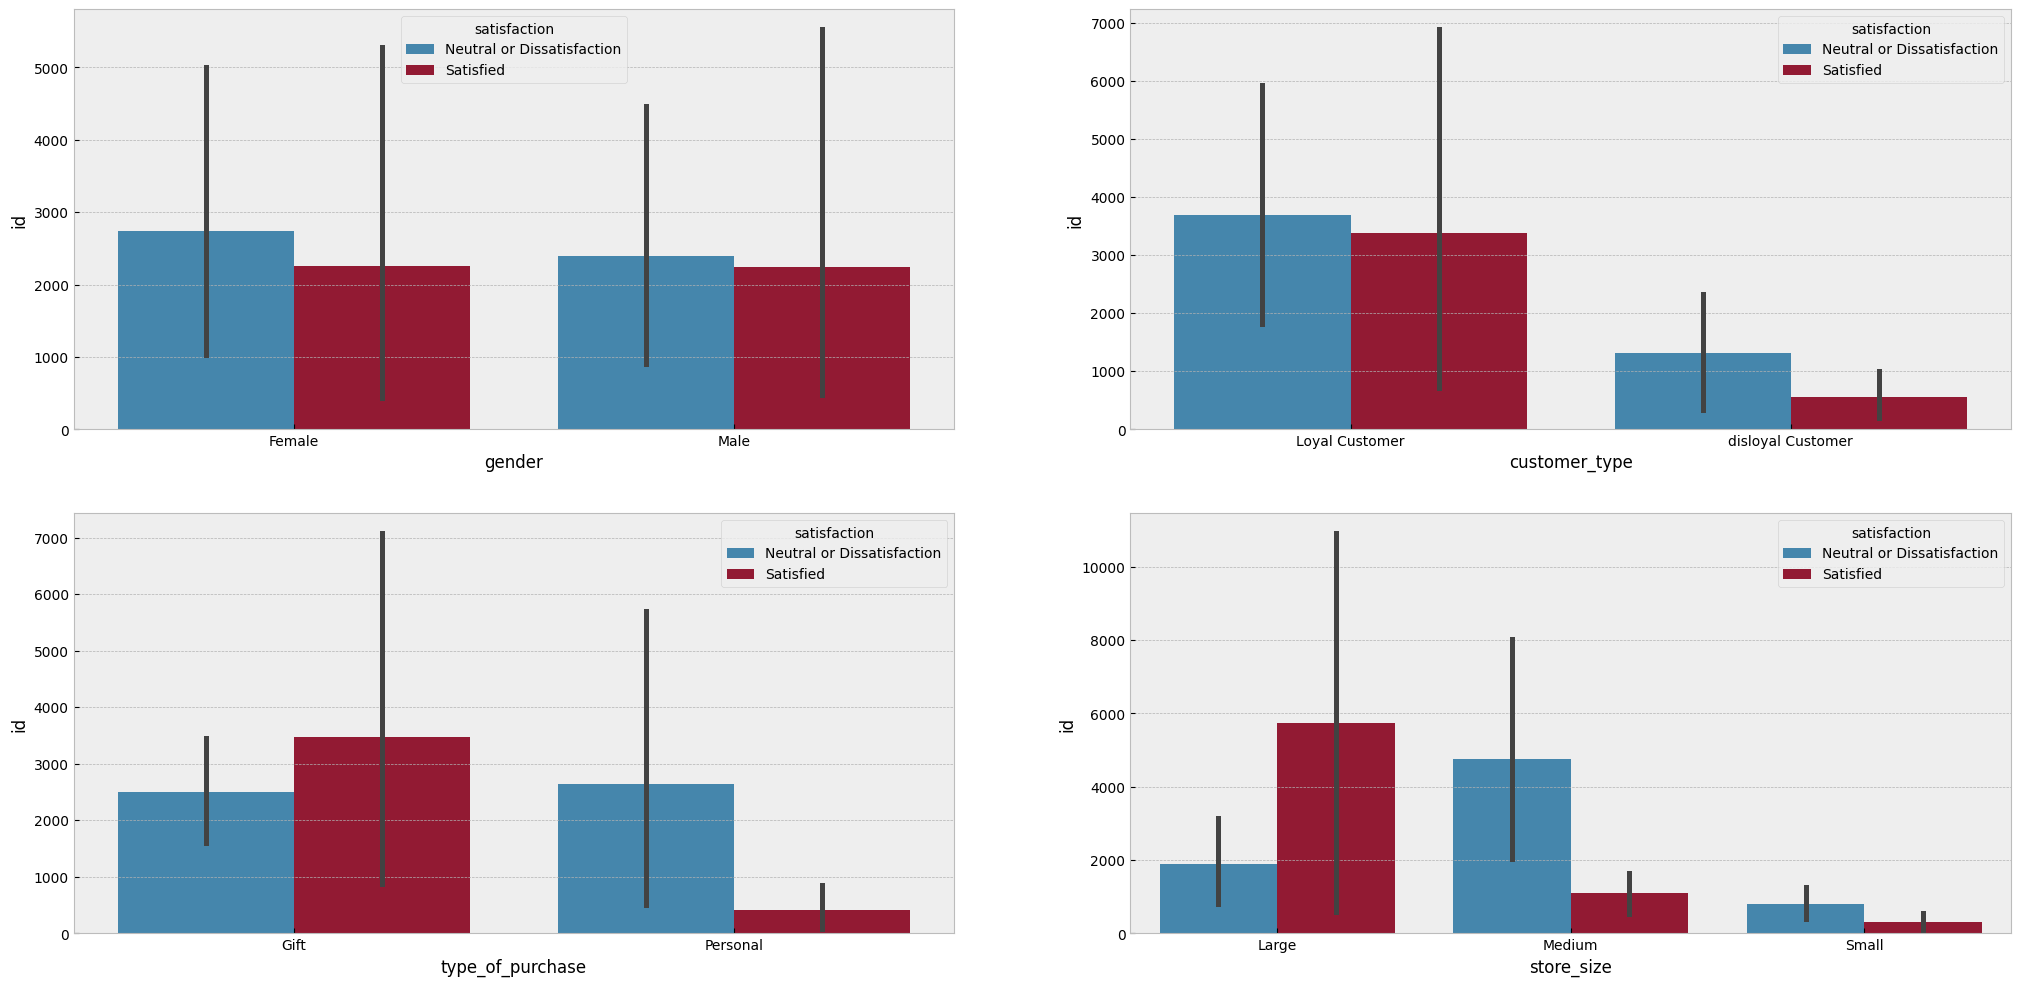

In [21]:
#Categorial Features Analysis on graph
aux1 = df1.loc[:,['id', 'gender', 'customer_type', 'type_of_purchase', 'store_size', 'satisfaction']].groupby(
                 ['gender', 'customer_type', 'type_of_purchase', 'store_size', 'satisfaction']).count().reset_index()

#Gender
plt.subplot(2,2,1)
sns.barplot(x='gender', y='id', hue='satisfaction', data=aux1)

#Customer Type
plt.subplot(2,2,2)
sns.barplot(x='customer_type', y='id', hue='satisfaction', data=aux1)

#Type of Purchase
plt.subplot(2,2,3)
sns.barplot(x='type_of_purchase', y='id', hue='satisfaction', data=aux1)

#Store Size
plt.subplot(2,2,4)
sns.barplot(x='store_size', y='id', hue='satisfaction', data=aux1);

### Categorical Feature Analysis by Response Variable

Gender: Balanced between Female and Male

Customer Type: Most customers are neutrally or dissatisfied between Loyal and Disloyal

Type of Purchase: Gift Purchase Customers are more satisfied than Personal Purchase Customers

Store Size: Most Satisfied Customers on Large Stores and Less Satisfied Customers on Small and Medium Stores

# 2.0. Feature Engineering

In [22]:
#Dataframe copy for data adjustment
df2 = df1.copy()
df2_x = df1_x.copy()

In [23]:
#Checking colmuns of train dataset
df2.columns

Index(['id', 'gender', 'customer_type', 'age', 'type_of_purchase',
       'store_size', 'store_distance', 'in_store_wifi',
       'open/close_time_convenient', 'easy_of_online_shopping',
       'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
       'kids_entertainment', 'seller_service', 'showroom', 'self_store',
       'purchase_service', 'store_service', 'cleanliness',
       'carrier_delay_in_minutes', 'delivery_delay_in_minutes',
       'satisfaction'],
      dtype='object')

### Feature Engineering:

df2['gender'].unique() -> 0/1

df2['customer type'].unique() -> 0/1

df2['type of purchase'].unique() -> 0/1

df2['store size'].unique() -> 0-2

f2['toilet cleaning'].unique() -> 0-5

in_store wifi -> 0-5

open/close time convenient -> 0-5

easy of online shopping -> 0-5

store location -> 0-5

toilet cleaning -> 0-5

dressing room -> 0-5

waiting room -> 0-5

kids entertainment -> 0-5

seller service -> 0-5

showroom -> 0-5

self_store -> 0-5

purchase service -> 0-5

store service -> 0-5

cleanliness -> 0-5

df2['age'].unique() -> min_max

df2['store distance'].describe() -> min_max / robust

df2['carrier delay in minutes'].describe() -> min_max / robust

df2['delivery delay in minutes'].describe() -> min_max / robust

In [24]:
#Applying Feature Engineering Function
df2 = feature_eng(df2, train=True)
df2_x = feature_eng(df2_x, train=False)

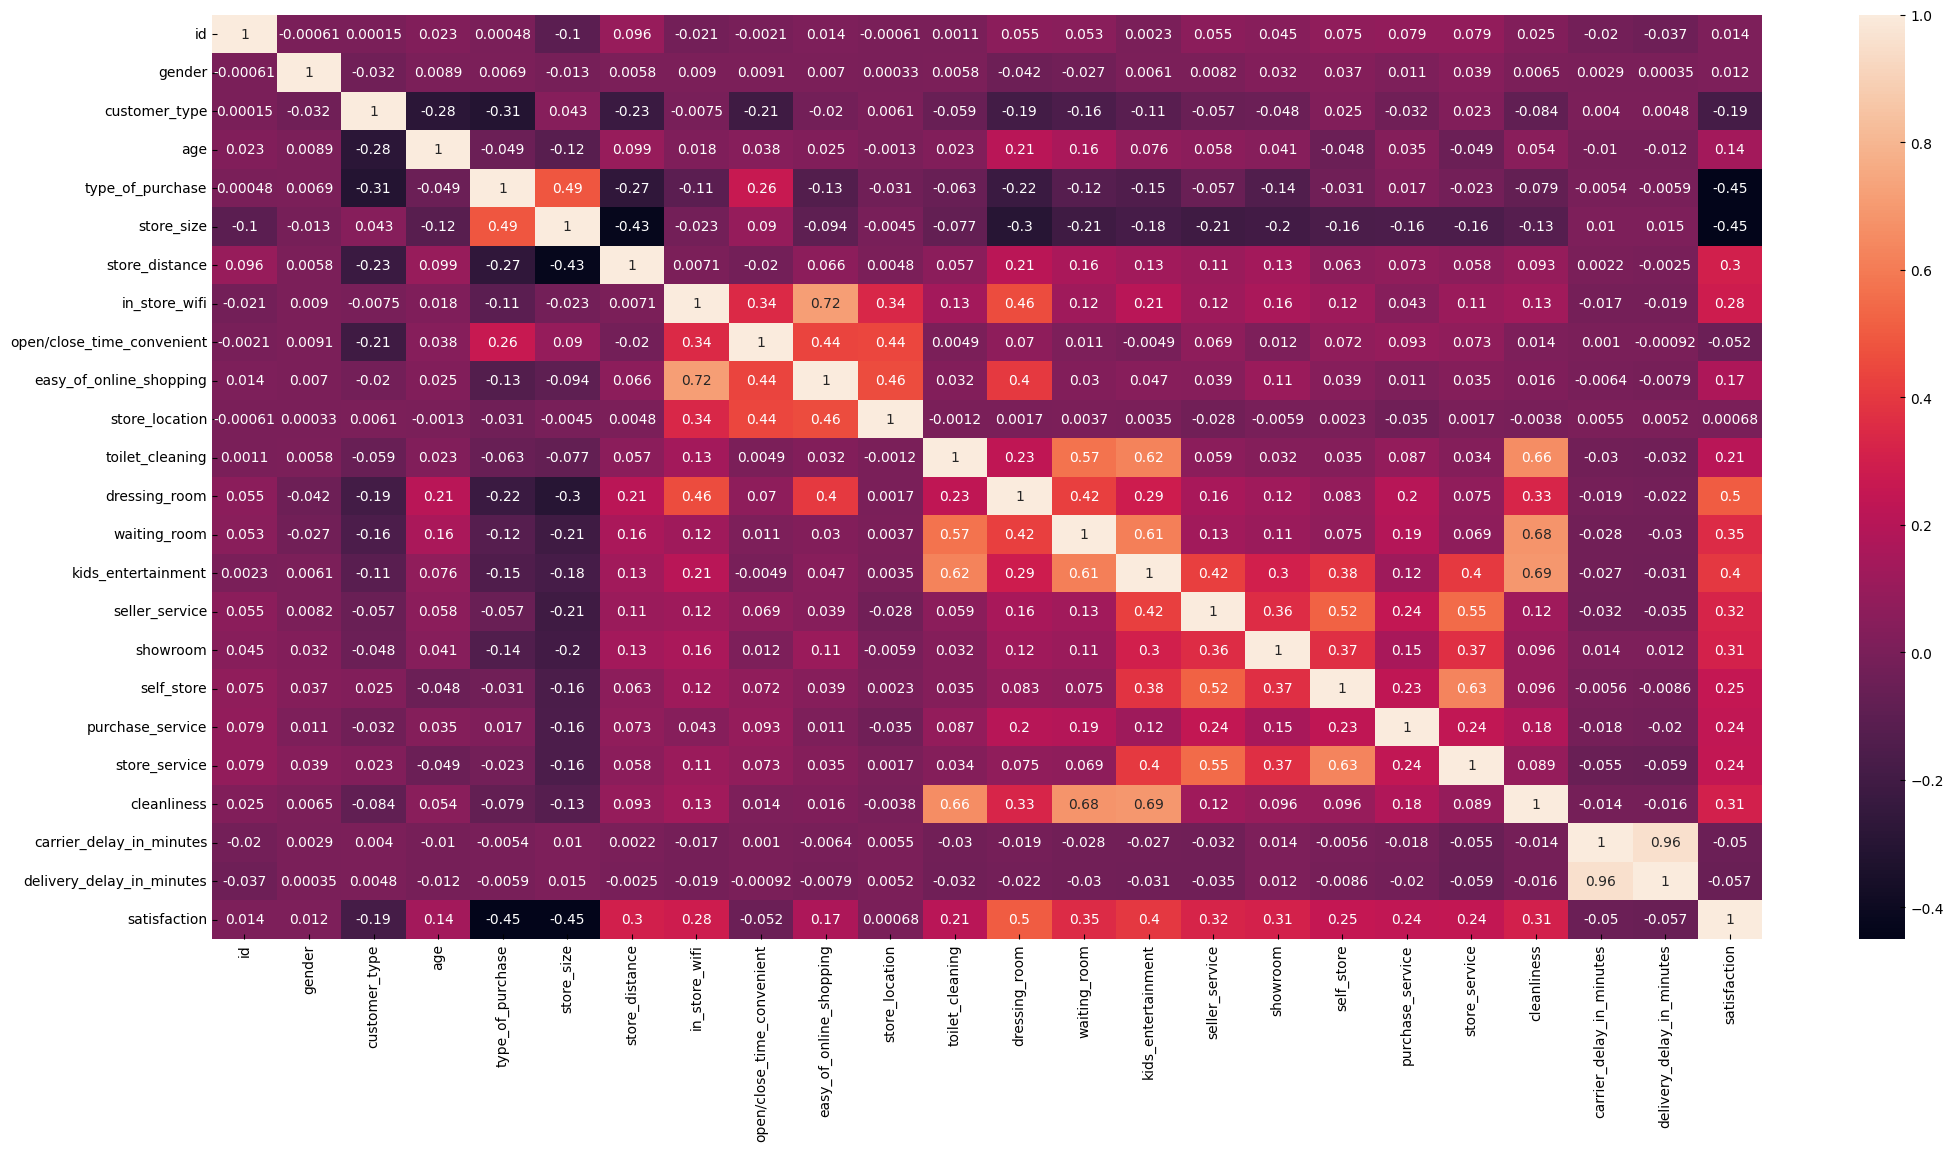

In [25]:
#Correlation of Response Variable - Heat Map (After Feature Engineering)
num_att2 = df2.select_dtypes(include=['int64', 'float64'])
hmap = num_att2.corr(method='pearson')
sns.heatmap(hmap, annot=True);

In [26]:
#Checking train data adjustments
df2

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,...,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction
0,70172,1,0,13,1,2,460,3,4,3,...,5,4,3,4,4,5,5,25,18.00,0
1,5047,1,1,25,0,0,235,3,2,3,...,1,1,5,3,1,4,1,1,6.00,0
2,110028,0,0,26,0,0,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.00,1
3,24026,0,0,25,0,0,562,2,5,5,...,2,2,5,3,1,4,2,11,9.00,0
4,119299,1,0,61,0,0,214,3,3,3,...,3,3,4,4,3,3,3,0,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,0,1,23,0,1,192,2,1,2,...,2,3,1,4,2,3,2,3,0.00,0
103900,73097,1,0,49,0,0,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.00,1
103901,68825,1,1,30,0,0,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.00,0
103902,54173,0,1,22,0,1,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.00,0


In [27]:
#Checking train data types
df2.dtypes

id                              int64
gender                          int64
customer_type                   int64
age                             int64
type_of_purchase                int64
store_size                      int64
store_distance                  int64
in_store_wifi                   int64
open/close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self_store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
satisfaction                    int64
dtype: object

In [28]:
#Checking test data adjustments
df2_x

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,...,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes
0,19556,0,0,52,0,1,160,5,4,3,...,3,5,5,5,5,2,5,5,50,44.00
1,90035,0,0,36,0,0,2863,1,1,3,...,5,4,4,4,4,3,4,5,0,0.00
2,12360,1,1,20,0,1,192,2,0,2,...,2,2,4,1,3,2,2,2,0,0.00
3,77959,1,0,44,0,0,3377,0,0,0,...,4,1,1,1,1,3,1,4,0,6.00
4,36875,0,0,49,0,1,1182,2,3,4,...,2,2,2,2,2,4,2,4,0,20.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,78463,1,1,34,0,0,526,3,3,3,...,4,4,3,2,4,4,5,4,0,0.00
25972,71167,1,0,23,0,0,646,4,4,4,...,4,4,4,5,5,5,5,4,0,0.00
25973,37675,0,0,17,1,1,828,2,5,1,...,2,2,4,3,4,5,4,2,0,0.00
25974,90086,1,0,14,0,0,1127,3,3,3,...,4,4,3,2,5,4,5,4,0,0.00


In [29]:
#Checking test data types
df2_x.dtypes

id                              int64
gender                          int64
customer_type                   int64
age                             int64
type_of_purchase                int64
store_size                      int64
store_distance                  int64
in_store_wifi                   int64
open/close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self_store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
dtype: object

# 3.0. Data Filtering

### After above analysis it was found that filtering the data will not be necessary

In [30]:
#Datasets copy for Data Filtering
df3 = df2.copy()
df3_x = df2_x.copy()

In [31]:
#Checking total of rows before filtering
print('Rows Before Filtering: {}'.format(df3.shape[0]))

#Checking total of rows after filtering
print('Rows After Filtering: {}'.format(df3.shape[0]))

Rows Before Filtering: 103904
Rows After Filtering: 103904


# 4.0. Data Preparation 

In [32]:
#Dataframe copy for Data Preparation
df4 = df3.copy()
df4_x = df3_x.copy()

In [33]:
#Setting Data to Algorithm Application
df4 = feature_opt(df4)
df4_x = feature_opt(df4_x)

In [34]:
#Checking train data
df4

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,...,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction
0,70172,1,0,0.08,1,2,-0.29,3,4,3,...,5,4,3,4,4,5,5,2.08,1.38,0
1,5047,1,1,0.23,0,0,-0.46,3,2,3,...,1,1,5,3,1,4,1,0.08,0.46,0
2,110028,0,0,0.24,0,0,0.22,2,2,2,...,5,4,3,4,4,4,5,0.00,0.00,1
3,24026,0,0,0.23,0,0,-0.21,2,5,5,...,2,2,5,3,1,4,2,0.92,0.69,0
4,119299,1,0,0.69,0,0,-0.47,3,3,3,...,3,3,4,4,3,3,3,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,0,1,0.21,0,1,-0.49,2,1,2,...,2,3,1,4,2,3,2,0.25,0.00,0
103900,73097,1,0,0.54,0,0,1.13,4,4,4,...,5,5,5,5,5,5,4,0.00,0.00,1
103901,68825,1,1,0.29,0,0,0.87,1,1,1,...,4,3,2,4,5,5,4,0.58,1.08,0
103902,54173,0,1,0.19,0,1,0.12,1,1,1,...,1,4,5,1,5,4,1,0.00,0.00,0


In [35]:
#Checking test data
df4_x

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,...,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes
0,19556,0,0,0.58,0,1,-0.52,5,4,3,...,3,5,5,5,5,2,5,5,4.17,3.38
1,90035,0,0,0.37,0,0,1.51,1,1,3,...,5,4,4,4,4,3,4,5,0.00,0.00
2,12360,1,1,0.17,0,1,-0.49,2,0,2,...,2,2,4,1,3,2,2,2,0.00,0.00
3,77959,1,0,0.47,0,0,1.90,0,0,0,...,4,1,1,1,1,3,1,4,0.00,0.46
4,36875,0,0,0.54,0,1,0.25,2,3,4,...,2,2,2,2,2,4,2,4,0.00,1.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,78463,1,1,0.35,0,0,-0.24,3,3,3,...,4,4,3,2,4,4,5,4,0.00,0.00
25972,71167,1,0,0.21,0,0,-0.15,4,4,4,...,4,4,4,5,5,5,5,4,0.00,0.00
25973,37675,0,0,0.13,1,1,-0.02,2,5,1,...,2,2,4,3,4,5,4,2,0.00,0.00
25974,90086,1,0,0.09,0,0,0.21,3,3,3,...,4,4,3,2,5,4,5,4,0.00,0.00


# 5.0. Feature Selection 

### After above analysis it was found that All Dataset Columns will be considered on the Models

In [36]:
#Dataframe copy for Feature Selection
df5 = df4.copy()
df5_x = df4_x.copy()

In [37]:
#Checking train data types for Machine Learning Application
df5.dtypes

id                              int64
gender                          int64
customer_type                   int64
age                           float64
type_of_purchase                int64
store_size                      int64
store_distance                float64
in_store_wifi                   int64
open/close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self_store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes      float64
delivery_delay_in_minutes     float64
satisfaction                    int64
dtype: object

In [38]:
#Checking test data types for Machine Learning Application
df5_x.dtypes

id                              int64
gender                          int64
customer_type                   int64
age                           float64
type_of_purchase                int64
store_size                      int64
store_distance                float64
in_store_wifi                   int64
open/close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self_store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes      float64
delivery_delay_in_minutes     float64
dtype: object

In [39]:
#Split train dataset into features and target
X = df5.drop(['satisfaction'], axis=1)
y = df5['satisfaction']

In [40]:
#Split train dataset into train and test for valuation
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2)

# 6.0. Machine Learning Model

## 6.1. XGBoost

In [ ]:
#Grid Search
#Model Definition
xgb_model = XGBClassifier(min_child_weight=1)

#Parameters Definition
parameters = {'n_estimators': [100, 200, 500, 1000],
              'max_depth': [10, 20, 40, 100]}

xgb_grd_src = GridSearchCV(estimator=xgb_model,
                           param_grid=parameters,
                           cv=cv,
                           scoring=scoring)

#Model Training
xgb_grdsrc_result = xgb_grd_src.fit(X_train, y_train)

#Score
print('Best Score: {:.5f}'.format(xgb_grdsrc_result.best_score_))
print('Best Parameters: {}'.format(xgb_grdsrc_result.best_params_))

Grid Search CV Results:

Best Score: 0.96909

Best Parameters: {'max_depth': 10, 'n_estimators': 100}

In [41]:
#Model Definition
xgb_model = XGBClassifier(n_estimators=100,
                          max_depth=10,
                          min_child_weight=1)

#Model Training
xgb_model.fit(X_train, y_train)

#Model Prediction
yhat_xgb = xgb_model.predict(X_val)

In [42]:
#Cross Validation XGB
xgb_cv = cross_val_score(xgb_model, X, y, scoring=scoring, cv=cv)
print(xgb_cv)
print('AVG CV: {:.5f}'.format(xgb_cv.mean()))
print('STD CV: {:.5f}'.format(xgb_cv.std()))

[0.96581003 0.96937734 0.96983891 0.97034333 0.97090578]
AVG CV: 0.96926
STD CV: 0.00180


In [ ]:
##Export the model pkl
#pickle.dump(xgb_model, open('xgb_model.pkl', 'wb' ))

### 6.1.1. Performance

In [43]:
#Show metrics of performance
precision = mt.precision_score(y_val, yhat_xgb)
avg_precision = mt.average_precision_score(y_val, yhat_xgb, average='micro')
recall = mt.recall_score(y_val, yhat_xgb)
f1_score = mt.f1_score(y_val, yhat_xgb, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.97024
AVG_Precision: 0.93844
Recall: 0.94074
F1 Score: 0.96096


## 6.2. Gradient Boosting

In [ ]:
#Grid Search
#Model Definition
gb_model = en.GradientBoostingClassifier(random_state=42)

#Parameters Definition
parameters = {'n_estimators': [100, 200],
              'max_depth': [10, 40]}

gb_grd_src = GridSearchCV(estimator=gb_model,
                           param_grid=parameters,
                           cv=cv,
                           scoring=scoring)

#Model Training
gb_grdsrc_result = gb_grd_src.fit(X_train, y_train)

#Score
print('Best Score: '.format(gb_grdsrc_result.best_score_))
print('Best Parameters: {}'.format(gb_grdsrc_result.best_params_))

Grid Search CV Results:

Best Score: 0.97256

Best Parameters: {'max_depth': 10, 'n_estimators': 200}

In [44]:
#Model Definition
gb_model = en.GradientBoostingClassifier(n_estimators=100,
                                          max_depth=10,
                                          random_state=42)

#Model Training
gb_model.fit(X_train, y_train)

#Model Prediction
yhat_gb = gb_model.predict(X_val)

In [45]:
#Cross Validation GB
gb_cv = cross_val_score(gb_model, X, y, scoring=scoring, cv=cv)
print(gb_cv)
print('AVG CV: {:.5f}'.format(gb_cv.mean()))
print('STD CV: {:.5f}'.format(gb_cv.std()))

[0.9710178  0.97265269 0.97080625 0.97588978 0.97431214]
AVG CV: 0.97294
STD CV: 0.00194


In [ ]:
##Export the model pkl
#pickle.dump(gb_model, open('gb_model.pkl', 'wb' ))

### 6.2.1. Performance

In [46]:
#Show metrics of performance
precision = mt.precision_score(y_val, yhat_gb)
avg_precision = mt.average_precision_score(y_val, yhat_gb, average='micro')
recall = mt.recall_score(y_val, yhat_gb)
f1_score = mt.f1_score(y_val, yhat_gb, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.97301
AVG_Precision: 0.94068
Recall: 0.94007
F1 Score: 0.96188


## 6.3. Random Forest

In [ ]:
#Grid Search
#Model Definition
rf_model = en.RandomForestClassifier(criterion='entropy', max_features='sqrt', bootstrap=False, n_jobs=-1, random_state=42)

#Parameters Definition
parameters = {'n_estimators': [2000, 3000],
              'max_depth': [30, 40],
              'min_samples_split': [2, 10],
              'min_samples_leaf': [1, 5]}

rf_grd_src = GridSearchCV(estimator=rf_model,
                           param_grid=parameters,
                           cv=cv,
                           scoring=scoring)

#Model Training
rf_grdsrc_result = rf_grd_src.fit(X_train, y_train)

#Score
print('Best Score: {:.5f}'.format(rf_grdsrc_result.best_score_))
print('Best Parameters: {}'.format(rf_grdsrc_result.best_params_))

Grid Search CV Results:

Best Score: 0.97566

Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30, 'n_estimators': 2000}

In [47]:
#Model Definition
rf_model = en.RandomForestClassifier(n_estimators=2000,
                                     max_depth=30,
                                     criterion='entropy',
                                     min_samples_split=10,
                                     min_samples_leaf=1,
                                     max_features='sqrt',
                                     bootstrap=False,
                                     n_jobs=-1,
                                     random_state=42)

#Model Training
rf_model.fit(X_train, y_train)

#Model Prediction
yhat_rf = rf_model.predict(X_val)

In [48]:
#Cross Validation RF
rf_cv = cross_val_score(rf_model, X, y, scoring=scoring, cv=cv)
print(rf_cv)
print('AVG CV: {:.5f}'.format(rf_cv.mean()))
print('STD CV: {:.5f}'.format(rf_cv.std()))

[0.97615757 0.97371729 0.97315282 0.97875779 0.97659208]
AVG CV: 0.97568
STD CV: 0.00204


In [ ]:
##Export the model pkl
#pickle.dump(rf_model, open('rf_model.pkl', 'wb' ))

### 6.3.1. Performance

In [49]:
#Show metrics of performance
precision = mt.precision_score(y_val, yhat_rf)
avg_precision = mt.average_precision_score(y_val, yhat_rf, average='micro')
recall = mt.recall_score(y_val, yhat_rf)
f1_score = mt.f1_score(y_val, yhat_rf, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.97574
AVG_Precision: 0.94168
Recall: 0.93719
F1 Score: 0.96180


## 6.4. LightGBM

In [ ]:
#Grid Search
#Model Definition
lgbm_model = LGBMClassifier(objective='binary', random_state=42, verbose=0)

#Parameters Definition
parameters = {'boosting_type': ['gbdt', 'dart'],
              'num_leaves': [45, 65],
              'max_depth': [20, 30]}

lgbm_grd_src = GridSearchCV(estimator=lgbm_model,
                           param_grid=parameters,
                           cv=cv,
                           scoring=scoring)

#Model Training
lgbm_grdsrc_result = lgbm_grd_src.fit(X_train, y_train)

#Score
print('Best Score: {:.5f}'.format(lgbm_grdsrc_result.best_score_))
print('Best Parameters: {}'.format(lgbm_grdsrc_result.best_params_))

Grid Search CV Results:

Best Score: 0.97568

Best Parameters: {'num_leaves': 65, 'max_depth': 20, 'boosting_type': 'dart'}

In [50]:
#Model Definition
lgbm_model = LGBMClassifier(boosting_type='dart',
                            num_leaves=65,
                            max_depth=20,
                            random_state=42,
                            verbose=0)

#Model Training
lgbm_model.fit(X_train, y_train)

#Model Prediction
yhat_lgbm = lgbm_model.predict(X_val)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007244 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [ ]:
##Export the model pkl
#pickle.dump(lgbm_model, open('lgbm_model.pkl', 'wb' ))

In [51]:
#Cross Validation LGBM
lgbm_cv = cross_val_score(lgbm_model, X, y, scoring=scoring, cv=cv)
print(lgbm_cv)
print('AVG CV: {:.5f}'.format(lgbm_cv.mean()))
print('STD CV: {:.5f}'.format(lgbm_cv.std()))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force

### 6.4.1. Performance

In [52]:
#Show metrics of performance
precision = mt.precision_score(y_val, yhat_lgbm)
avg_precision = mt.average_precision_score(y_val, yhat_lgbm, average='micro')
recall = mt.recall_score(y_val, yhat_lgbm)
f1_score = mt.f1_score(y_val, yhat_lgbm, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.97165
AVG_Precision: 0.93702
Recall: 0.93563
F1 Score: 0.95935


## 6.5. Voting Classifier

In [53]:
#Model Definition
v_class = en.VotingClassifier(estimators=[('yhat_xgb', xgb_model),
                                          ('yhat_gb', gb_model),
                                          ('yhat_rf', rf_model),
                                          ('yhat_lgbm', lgbm_model)],
                                          voting='soft',
                                          weights=[1, 2, 2, 2])

#Model Trainning
v_class.fit(X_train, y_train)

#Model Prediction
yhat_vc = v_class.predict(X_val)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [ ]:
##Export the model pkl
#pickle.dump(v_class, open('v_class.pkl', 'wb' ))

### 6.5.1. Performance

In [54]:
#Show metrics of performance Voting Classfier
precision = mt.precision_score(y_val, yhat_vc)
avg_precision = mt.average_precision_score(y_val, yhat_vc, average='micro')
recall = mt.recall_score(y_val, yhat_vc)
f1_score = mt.f1_score(y_val, yhat_vc, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.97590
AVG_Precision: 0.94292
Recall: 0.93919
F1 Score: 0.96274


# 7.0. Ensemble

In [55]:
#Merge data to compare
ensemble = pd.DataFrame([yhat_xgb, yhat_gb, yhat_rf, yhat_lgbm]).T
ensemble.columns = ['yhat_xgb', 'yhat_gb', 'yhat_rf', 'yhat_lgbm']
moda = ensemble.mode(axis=1)[0]
ensemble['pred'] = moda

# 8.0. General Performance

In [56]:
#Collect values for test performance
yhat_en = ensemble['pred']

In [57]:
#Show metrics of performance
precision = mt.precision_score(y_val, yhat_en)
avg_precision = mt.average_precision_score(y_val, yhat_en, average='micro')
recall = mt.recall_score(y_val, yhat_en)
f1_score = mt.f1_score(y_val, yhat_en, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.97944
AVG_Precision: 0.94424
Recall: 0.93552
F1 Score: 0.96266


# 9.0. Model Application to Test Data

In [58]:
#XGBoost application to test data
yhat_xbg_x = xgb_model.predict(df5_x)

#Gradient Boosting application to test data
yhat_gb_x = gb_model.predict(df5_x)

#Random Forest application to test data
yhat_rf_x = rf_model.predict(df5_x)

#LGBM application to test data
yhat_lgbm_x =lgbm_model.predict(df5_x)

#Voting Classifier application to test data
yhat_vc_x = v_class.predict(df5_x)

# 10.0. Export CSV

In [59]:
#Prepare data to export Ensemble
ensemble = pd.DataFrame([yhat_xgb, yhat_gb, yhat_rf, yhat_lgbm]).T
ensemble.columns = ['yhat_xgb', 'yhat_gb', 'yhat_rf', 'yhat_lgbm']
moda_x = ensemble.mode(axis=1)[0]
ensemble['pred'] = moda_x

yhat_final = ensemble['pred']
df4_x['satisfaction'] = yhat_final
predict = df4_x[['id', 'satisfaction']].copy()

#Export data
predict.to_csv('data/predict.csv', index=False)

In [60]:
#Prepare data to export XGB results
yhat = yhat_xbg_x
df4_x['satisfaction'] = yhat
predict = df4_x[['id', 'satisfaction']].copy()

#Export data
predict.to_csv('data/xgb_predict.csv', index=False)

In [61]:
#Prepare data to export GB results
yhat = yhat_gb_x
df4_x['satisfaction'] = yhat
predict = df4_x[['id', 'satisfaction']].copy()

#Export data
predict.to_csv('data/gb_predict.csv', index=False)

In [62]:
#Prepare data to export RF results
yhat = yhat_rf_x
df4_x['satisfaction'] = yhat
predict = df4_x[['id', 'satisfaction']].copy()

#Export data
predict.to_csv('data/rf_predict.csv', index=False)

In [63]:
#Prepare data to export LGBM results
yhat = yhat_lgbm_x
df4_x['satisfaction'] = yhat
predict = df4_x[['id', 'satisfaction']].copy()

#Export data
predict.to_csv('data/lgbm_predict.csv', index=False)

In [64]:
#Prepare data to export V_Class results
yhat = yhat_vc_x
df4_x['satisfaction'] = yhat
predict = df4_x[['id', 'satisfaction']].copy()

#Export data
predict.to_csv('data/vclass_predict.csv', index=False)